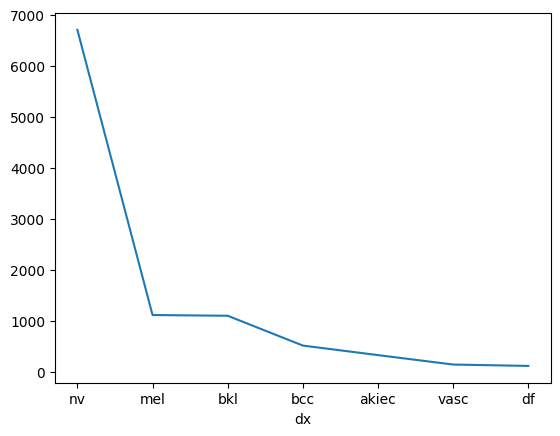

In [6]:

import numpy as np 
import pandas as pd 

# Data Loading
data = pd.read_csv("D:/ML Projects/Skin Cancer Prediction (DSN2099)/DSN 3009 Skin Cancer Prediction/DATASET/hmnist_28_28_RGB.csv")
data.head()
meta_df = pd.read_csv("D:/ML Projects/Skin Cancer Prediction (DSN2099)/DSN 3009 Skin Cancer Prediction/DATASET/HAM10000_metadata.csv")
meta_df.head()
meta_df.shape
data.shape
yData = data['label']
XData = data.drop(columns = ['label'])
# EDA
distribution = meta_df['dx'].value_counts()
distribution
# classes = {4: ('nv', ' melanocytic nevi'),
#            6: ('mel', 'melanoma'),
#            2 :('bkl', 'benign keratosis-like lesions'), 
#            1:('bcc' , ' basal cell carcinoma'),
#            5: ('vasc', ' pyogenic granulomas and hemorrhage'),
#            0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
#            3: ('df', 'dermatofibroma')}
dist = data['label'].value_counts()
dist

distribution.plot()
# Fixing Data Imbalance


from imblearn.over_sampling import RandomOverSampler 







In [7]:
import sys
print(sys.getsizeof(data))


188522504


In [8]:
sampler = RandomOverSampler()
XData,yData  = sampler.fit_resample(XData,yData)
XData.shape, yData.shape
XData = np.array(XData).reshape((-1, 28, 28, 3))
XData = XData / 255
XData.shape
# Create the train and validation set
from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(XData,yData, test_size=0.2)
Xtrain.shape, Xtest.shape

# Train the model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
import tensorflow as tf

img_width, img_height = 28,28

input_shape = (img_width, img_height, 3)
model = Sequential()
model.add(Conv2D(32, (2, 2), input_shape=input_shape))
model.add(Activation('swish'))
model.add(MaxPooling2D(pool_size=(2, 2)))

MemoryError: Unable to allocate 114. MiB for an array with shape (2352, 6378) and data type int64

In [ ]:
model.add(Conv2D(32, (2, 2)))
model.add(Activation('swish'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (2, 2)))
model.add(Activation('swish'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('swish'))
model.add(Dropout(0.5))
model.add(Dense(7))
model.add(Activation('softmax'))

model.compile(loss='sparse_categorical_crossentropy',
optimizer='nadam',
metrics=['accuracy'])

In [ ]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='skin.h5',
                                                  monitor='val_acc', mode='max',
                                                 verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(Xtrain,
                    Ytrain,
                    epochs = 100,
                    validation_data = (Xtest, Ytest),
                    callbacks=[callback, early_stopping])
import matplotlib.pyplot as plt
model.evaluate(Xtrain, Ytrain)
model.evaluate(Xtest, Ytest)

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)

In [ ]:

plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()
history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()